## setting

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
import torch
import torch.nn as nn
import numpy as np
import sys
sys.path.append("/content/drive/My Drive/LCNN/")

import os
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt



import imp
import importlib
import LCNN
imp.reload(LCNN)
from LCNN import adjust,accuracy,one_hot
device = torch.device('cuda')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu2 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)
        self.fc3.weight.detach().uniform_(-1, 1)
        self.fc3.bias.detach().uniform_(-1, 1)
        self.fc4.weight.detach().uniform_(-1,1)





        self.lsm=nn.LogSoftmax(dim=1)
    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc3(out)
        out = out/np.sqrt(hidden_size2)
        out = self.relu2(out)
        out = self.fc4(out)
        out = out/np.sqrt(hidden_size3)
        return out

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


In [ ]:
transform = transforms.Compose([transforms.ToTensor(),
                              transforms.Normalize((0.5,), (0.5,)),
                              ])
batchsize=64

trainset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=True, transform=transform)
valset = datasets.MNIST('/content/drive/My Drive/data', download=True, train=False, transform=transform)
train_loader = torch.utils.data.DataLoader(trainset, batch_size=batchsize, shuffle=False)
valloader = torch.utils.data.DataLoader(valset, batch_size=batchsize, shuffle=False)

## LCNN

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


#for prob in [0,1,2]:
for prob in [1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  



        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,aclist])

outLCNN=out

Adjusting Layer 1, Kernel Nodes: 495, Adptive Nodes305
1 0 0.10614407062530518
Accuracy: 12.1700 %
1 10 0.07562797516584396
Accuracy: 40.2800 %
1 20 0.05348842218518257
Accuracy: 52.9100 %
1 30 0.03910641744732857
Accuracy: 58.0100 %
1 40 0.029800185933709145
Accuracy: 61.2900 %
1 50 0.023469949141144753
Accuracy: 62.7700 %
1 60 0.018718047067523003
Accuracy: 63.5700 %
1 70 0.015132891945540905
Accuracy: 64.5800 %
1 80 0.012347418814897537
Accuracy: 64.9600 %
1 90 0.010127504356205463
Accuracy: 65.2400 %
1 100 0.008340952917933464
Accuracy: 65.3900 %
1 110 0.006886818911880255
Accuracy: 65.2900 %
1 120 0.0057035028003156185
Accuracy: 65.2700 %
1 130 0.004744993057101965
Accuracy: 65.2900 %
1 140 0.0039595263078808784
Accuracy: 65.1600 %
1 150 0.0033129944931715727
Accuracy: 65.0700 %
1 160 0.002782620256766677
Accuracy: 65.0100 %
1 170 0.0023442243691533804
Accuracy: 64.8500 %
1 180 0.001982577843591571
Accuracy: 64.7300 %
1 190 0.0016844451893121004
Accuracy: 64.6800 %
1 200 0.0014364

KeyboardInterrupt: ignored

## Batch

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(num_features=hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.bn2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


for prob in [0,1,2]:
#for prob in [1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=10
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  



        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,aclist])

outdec=out

0 0 0.2559715211391449
Accuracy: 10.7100 %
0 10 0.10491733998060226
Accuracy: 19.1000 %
0 20 0.05579107999801636
Accuracy: 24.8900 %
0 30 0.03333641216158867
Accuracy: 28.6900 %
0 40 0.021682241931557655
Accuracy: 31.1000 %
0 50 0.014946958981454372
Accuracy: 33.0600 %
0 60 0.010803009383380413
Accuracy: 34.1700 %
0 70 0.008114008232951164
Accuracy: 35.1000 %
0 80 0.006266708951443434
Accuracy: 35.7300 %
0 90 0.004930482711642981
Accuracy: 36.3300 %
0 100 0.003953251522034407
Accuracy: 36.7200 %
0 110 0.0032149243634194136
Accuracy: 37.0600 %
0 120 0.002644418505951762
Accuracy: 37.2100 %
0 130 0.0021974132396280766
Accuracy: 37.4600 %
0 140 0.001841672114096582
Accuracy: 37.8000 %
0 150 0.0015552400145679712
Accuracy: 37.9500 %
0 160 0.001321755931712687
Accuracy: 38.1100 %
0 170 0.0011295437579974532
Accuracy: 38.1300 %
Adjusting Layer 1, Kernel Nodes: 649, Adptive Nodes151
1 0 0.24661557376384735
Accuracy: 26.5500 %
1 10 0.028225356712937355
Accuracy: 45.7900 %
1 20 0.01126016210764

Text(0.5, 0, 'Step')

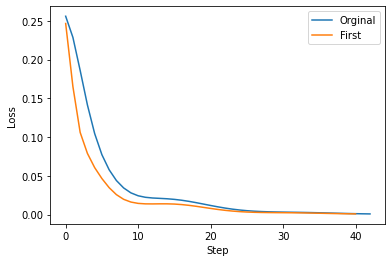

In [ ]:
plt.plot(outdec[0][0],'-',label='Orginal')
plt.plot(outdec[1][0],'-',label='First')
#plt.plot(outdec[2][0],'-',label='First+Second')
plt.legend()
plt.ylabel('Loss')
plt.xlabel('Step')

## Batch Norm CNN

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(num_features=hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.bn2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
out=[]
for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    aclist=[]
    for runsteps in range(1000*20):
        if runsteps %10000==0:

            H=torch.zeros([batch_size,batch_size])
            numberparameter=len(model.state_dict())

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()
        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,elist,aclist])
outc=out

0 0 0.2420109063386917
Accuracy: 10.6800 %
0 10 0.024878183379769325
Accuracy: 44.4100 %
0 20 0.011139879934489727
Accuracy: 47.4600 %
0 30 0.0030085057951509953
Accuracy: 49.7400 %
0 40 0.0008893779595382512
Accuracy: 50.4200 %


IndexError: ignored

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

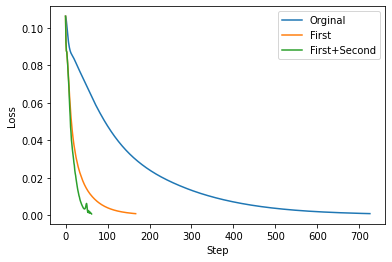

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

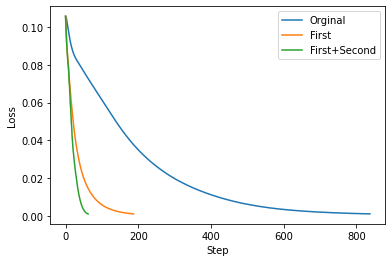

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
tb = widgets.TabBar(['dec', 'c'])
with tb.output_to('dec'):
    plt.plot(outdec[0][0],'-',label='Orginal')
    plt.plot(outdec[1][0],'-',label='First')
    plt.plot(outdec[2][0],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

with tb.output_to('c'):
    plt.plot(outc[0][0],'-',label='Orginal')
    plt.plot(outc[1][0],'-',label='First')
    plt.plot(outc[2][0],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

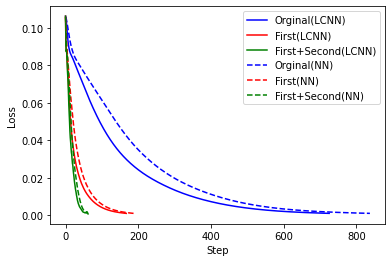

In [ ]:
    plt.plot(outdec[0][0],'-',color='blue',label='Orginal(LCNN)')
    plt.plot(outdec[1][0],'-',color='red',label='First(LCNN)')
    plt.plot(outdec[2][0],'-',color='green',label='First+Second(LCNN)')
    plt.plot(outc[0][0],'--',color='blue',label='Orginal(NN)')
    plt.plot(outc[1][0],'--',color='red',label='First(NN)')
    plt.plot(outc[2][0],'--',color='green',label='First+Second(NN)')

    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')
    plt.savefig('/content/drive/My Drive/LCNN/plot/compare2.pdf')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

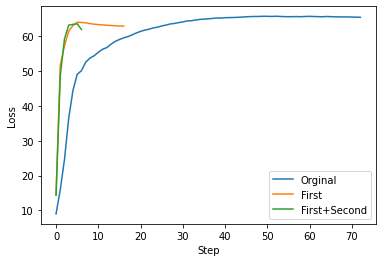

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

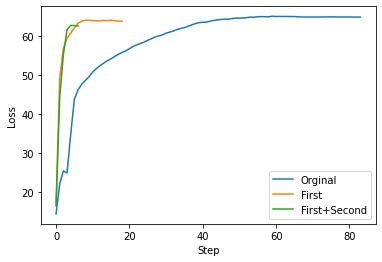

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import widgets
tb = widgets.TabBar(['dec', 'c'])
with tb.output_to('dec'):
    plt.plot(outdec[0][2],'-',label='Orginal')
    plt.plot(outdec[1][2],'-',label='First')
    plt.plot(outdec[2][2],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

with tb.output_to('c'):
    plt.plot(outc[0][2],'-',label='Orginal')
    plt.plot(outc[1][2],'-',label='First')
    plt.plot(outc[2][2],'-',label='First+Second')
    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')

No handles with labels found to put in legend.


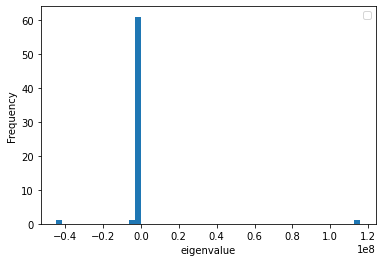

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 200

hidden_size3 = 100


num_classes = 10
batch_size = 64


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2,bias=False)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes,bias=False)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        #out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out
eigenvaluepolt=True
outputindex=1     
if eigenvaluepolt:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)

    H=torch.zeros([batch_size,batch_size])
    numberparameter=len(model.state_dict())
    for i in range(batch_size):
            image=images[i]
            outputs = model(image).to(device)
            loss = criterion(outputs, label).to(device)
            optimizer.zero_grad()
            loss.backward()
            
            Pigrad=[]
            pindex=0
            for p in model.parameters():
                Pigrad.append(p.grad.detach())
            for j in range(i):
                image=images[i]
                outputs = model(image).to(device)[outputindex]
                outputs.backward(torch.ones_like(outputs))
                Pjgrad=[]
                pjndex=0
                for p in model.parameters():
                    Pjgrad.append(p.grad.detach())
                with torch.no_grad():
                    ij=0
                    for iii in range(numberparameter):
                        ij=torch.sum(Pjgrad[iii]*Pigrad[iii])
                    H[i][j]=ij
                    H[j][i]=ij
            with torch.no_grad():
                ij=0
                for iii in range(numberparameter):
                    ij=torch.sum(Pigrad[iii]*Pigrad[iii])
                H[i][i]=ij
    eig=torch.eig(H)           
    eigenvaluem=eig[0][:,0].cpu().data.detach().numpy()
    plt.hist(eigenvaluem, bins=50) 
    plt.legend()
    plt.ylabel('Frequency')
    plt.xlabel('eigenvalue')


In [ ]:
torch.sum(torch.tensor([[1,2],[1,2]])*torch.tensor([[1,2],[1,2]]))

tensor(10)

In [ ]:
for name in model.state_dict():
    print(name)

fc1.weight
fc1.bias
bn1.weight
bn1.bias
bn1.running_mean
bn1.running_var
bn1.num_batches_tracked
fc2.weight
bn2.weight
bn2.bias
bn2.running_mean
bn2.running_var
bn2.num_batches_tracked
fc3.weight
fc3.bias
bn3.weight
bn3.bias
bn3.running_mean
bn3.running_var
bn3.num_batches_tracked
fc4.weight


In [ ]:
for name, param in model.named_parameters():
    print(name)

fc1.weight
fc1.bias
bn1.weight
bn1.bias
fc2.weight
bn2.weight
bn2.bias
fc3.weight
fc3.bias
bn3.weight
bn3.bias
fc4.weight


In [ ]:
for name in model.named_parameters():
    print(name)

('fc1.weight', Parameter containing:
tensor([[-0.0721,  0.0119, -0.3393,  ...,  0.3477,  0.0608, -0.3281],
        [-0.2077, -0.0661, -0.1952,  ..., -0.0257,  0.0964,  0.0484],
        [-0.0688,  0.2867,  0.0527,  ..., -0.0652, -0.0653, -0.1964],
        ...,
        [ 0.0114, -0.0125,  0.0096,  ..., -0.0309, -0.0110,  0.0197],
        [ 0.0304,  0.0343,  0.0267,  ..., -0.0321,  0.0016,  0.0131],
        [ 0.0289, -0.0086,  0.0159,  ...,  0.0101, -0.0167, -0.0329]],
       requires_grad=True))
('fc1.bias', Parameter containing:
tensor([-3.4325e-01,  1.2457e-01,  2.6075e-01,  2.2121e-01,  3.7896e-02,
        -2.1699e-02, -1.7046e-02,  2.6310e-03, -9.0592e-02,  8.0363e-02,
        -3.4253e-01,  2.0068e-01, -2.5828e-01,  2.8437e-01, -2.8681e-01,
        -3.3717e-01,  3.2848e-01,  2.9202e-01, -2.4788e-01,  3.0331e-02,
        -8.3832e-03,  1.0849e-01, -4.5584e-02, -1.9824e-01, -8.5809e-02,
        -3.0288e-01, -2.7510e-02, -1.5685e-01,  1.0977e-02,  2.0434e-01,
         2.1408e-01, -2.7692

In [ ]:
a='bn1.running_mean'

In [ ]:
a[4:]

'running_mean'

# Full connected

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 80

hidden_size2 = 20

hidden_size3 = 10


num_classes = 10
batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


#for prob in [0,1,2]:
#for prob in [1,2]:
for prob in [2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=0
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  



        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.01:
            break
    out.append([losslist,aclist])

outLCNN=out

Adjusting Layer 1, Kernel Nodes: 68, Adptive Nodes12
1 0 0.16783003509044647
Accuracy: 9.7300 %
1 10 0.14182673394680023
Accuracy: 9.7700 %
1 20 0.12377047538757324
Accuracy: 11.1200 %
1 30 0.10655839741230011
Accuracy: 14.8800 %
1 40 0.09509803354740143
Accuracy: 16.4700 %
1 50 0.08757318556308746
Accuracy: 18.0000 %
1 60 0.08260305970907211
Accuracy: 19.3100 %
1 70 0.07957973331212997
Accuracy: 19.8400 %
1 80 0.07754730433225632
Accuracy: 21.4600 %
1 90 0.07604088634252548
Accuracy: 26.0300 %
1 100 0.07476450502872467
Accuracy: 28.8200 %
1 110 0.07362061738967896
Accuracy: 30.6300 %
1 120 0.0725957378745079
Accuracy: 32.1200 %
1 130 0.07164008915424347
Accuracy: 33.4200 %
1 140 0.07074590027332306
Accuracy: 34.3700 %
1 150 0.06997325271368027
Accuracy: 35.2800 %
1 160 0.06919949501752853
Accuracy: 35.7300 %
1 170 0.06846695393323898
Accuracy: 36.3200 %
1 180 0.06776274740695953
Accuracy: 36.6900 %
1 190 0.06706516444683075
Accuracy: 36.9300 %
1 200 0.06641747802495956
Accuracy: 37.25

KeyboardInterrupt: ignored

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 80

hidden_size2 = 20

hidden_size3 = 10


num_classes = 10
batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1) 

        
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.bn2 = nn.BatchNorm1d(num_features=hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.bn3 = nn.BatchNorm1d(num_features=hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.bn2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.bn3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        return out


for prob in [0,1,2]:
#for prob in [1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=10
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1)  



        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.00001:
            break
    out.append([losslist,aclist])

outBatch=out

0 0 0.346698522567749
Accuracy: 11.0100 %
0 10 0.1492394655942917
Accuracy: 16.5500 %
0 20 0.08296068757772446
Accuracy: 24.2900 %
0 30 0.05840456113219261
Accuracy: 29.8300 %
0 40 0.050088562071323395
Accuracy: 31.5100 %
0 50 0.04640137776732445
Accuracy: 32.2100 %
0 60 0.04397503659129143
Accuracy: 32.9800 %
0 70 0.042113710194826126
Accuracy: 33.4000 %
0 80 0.04051820561289787
Accuracy: 33.8100 %
0 90 0.039084386080503464
Accuracy: 34.1400 %
0 100 0.037764471024274826
Accuracy: 34.5900 %
0 110 0.036543287336826324
Accuracy: 35.0800 %
0 120 0.03527785465121269
Accuracy: 35.5100 %
0 130 0.0340682752430439
Accuracy: 35.9300 %
0 140 0.03286778926849365
Accuracy: 36.2900 %
0 150 0.031771402806043625
Accuracy: 36.7500 %
0 160 0.03073298931121826
Accuracy: 37.2100 %
0 170 0.029700210317969322
Accuracy: 37.5700 %
0 180 0.028716666623950005
Accuracy: 37.8200 %
0 190 0.027699369937181473
Accuracy: 38.0200 %
0 200 0.02676786296069622
Accuracy: 38.4200 %
0 210 0.02587684988975525
Accuracy: 38.7

KeyboardInterrupt: ignored

# 8 Layers

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

hidden_size2 = 400

hidden_size3 = 200

hidden_size4 = 100

hidden_size5 = 50

hidden_size6 = 20

hidden_size7 = 10

num_classes = 10

batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, hidden_size2)
        self.relu2 = nn.ReLU()

        
        
        self.fc3 = nn.Linear(hidden_size2, hidden_size3)
        self.relu3 = nn.ReLU()
        self.fc4 = nn.Linear(hidden_size3, hidden_size4)
        self.relu4 = nn.ReLU()

        self.fc5 = nn.Linear(hidden_size4, hidden_size5)
        self.relu5 = nn.ReLU()
        self.fc6 = nn.Linear(hidden_size5, hidden_size6)
        self.relu6 = nn.ReLU()

        self.fc7 = nn.Linear(hidden_size6, hidden_size7)
        self.relu7 = nn.ReLU()
        self.fc8 = nn.Linear(hidden_size7, num_classes)

    
    def forward(self, x):
        out = self.fc1(x)
        out = self.relu1(out)
        out = self.fc2(out)
        out = self.relu2(out)
        out = self.fc3(out)
        out = self.relu3(out)
        out = self.fc4(out)
        out = self.relu4(out)
        out = self.fc5(x)
        out = self.relu5(out)
        out = self.fc6(out)
        out = self.relu6(out)
        out = self.fc7(out)
        out = self.relu7(out)
        out = self.fc8(out)
        return out


for prob in [0,1,2]:
    learning_rate = 0.01
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,hidden_size2,hidden_size3,hidden_size4,hidden_size5,hidden_size6,hidden_size7,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=1
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.1,scale=0.4,ln=1,oflag=1)

        if prob>1 and runsteps==de:
            model.fc2.register_forward_hook(get_activation('fc2'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1) 

        if prob>1 and runsteps==de:
            model.fc4.register_forward_hook(get_activation('fc4'))
            output = model(images)
            adjust(model,activation['fc'+str(2)],threshold_u=10,threshold_l=0.1,scale=0.2,ln=3,oflag=1) 
        
        
        
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,aclist])

outLCNN=out

RuntimeError: ignored

# 2 layer

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10

batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.relu1 = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)
        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)


    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.relu1(out)
        out = out/np.sqrt(hidden_size1)
        out = self.fc2(out)
        return out


for prob in [0,1]:
    learning_rate = 0.2
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=1
    aclist=[]

    
    for runsteps in range(1000*20):

        

        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.5,ln=1,oflag=1)
        
        
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.01:
            break
    out.append([losslist,aclist])

outLCNN=out

0 0 0.16779623925685883
Accuracy: 8.7500 %
0 10 0.12873263657093048
Accuracy: 9.8700 %
0 20 0.09801061451435089
Accuracy: 12.9500 %
0 30 0.09223230183124542
Accuracy: 17.0100 %
0 40 0.09066157788038254
Accuracy: 18.9100 %
0 50 0.08792826533317566
Accuracy: 20.5100 %
0 60 0.08534368127584457
Accuracy: 21.6900 %
0 70 0.08320730924606323
Accuracy: 23.0600 %
0 80 0.08123738318681717
Accuracy: 25.0200 %
0 90 0.07933598756790161
Accuracy: 26.8600 %
0 100 0.07751218974590302
Accuracy: 28.7600 %
0 110 0.07576587051153183
Accuracy: 30.4900 %
0 120 0.07409711927175522
Accuracy: 32.0900 %
0 130 0.07250238955020905
Accuracy: 33.7500 %
0 140 0.07097511738538742
Accuracy: 35.3500 %
0 150 0.06950955837965012
Accuracy: 37.1200 %
0 160 0.06810054183006287
Accuracy: 38.7000 %
0 170 0.0667450949549675
Accuracy: 40.2200 %
0 180 0.06544313579797745
Accuracy: 41.3300 %
0 190 0.0641881451010704
Accuracy: 42.6800 %
0 200 0.06297942996025085
Accuracy: 43.8600 %
0 210 0.061816465109586716
Accuracy: 44.7700 %
0 

In [ ]:
# Device configuration
device = torch.device('cuda')
# Hyper-parameters 
input_size = 784

hidden_size1 = 800

num_classes = 10

batch_size = 64

out=[]

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook


class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size1,num_classes):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size1)  
        self.bn1 = nn.BatchNorm1d(num_features=hidden_size1)
        self.relu1 = nn.ReLU()
        
        self.fc2 = nn.Linear(hidden_size1, num_classes,bias=False)


        self.fc1.weight.detach().uniform_(-1, 1)
        self.fc1.bias.detach().uniform_(-1, 1)
        self.fc2.weight.detach().uniform_(-1,1)


    
    def forward(self, x):
        out = self.fc1(x)
        out = out/np.sqrt(input_size)
        out = self.bn1(out)
        out = self.relu1(out)
        out = self.fc2(out)
        out = out/np.sqrt(hidden_size1)
        return out


for prob in [0,1]:
    learning_rate = 0.2
    torch.manual_seed(0)
    device = torch.device('cuda')
    model = NeuralNet(input_size, hidden_size1,num_classes).to(device)

    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate,momentum=0.9)
    criterion = nn.MSELoss()

    dataiter = iter(train_loader)
    images, labels = dataiter.next()
    images = images.view(images.shape[0], -1).to(device)
    labels =one_hot(labels,num_classes).to(device)



    losslist=[]
    elist=[]
    de=1
    aclist=[]

    
    for runsteps in range(1000*20):
        if prob>0 and runsteps==0:
            adjust(model,images,threshold_u=10,threshold_l=0.01,scale=0.5,ln=1,oflag=1)
        outputs = model(images).to(device)
        loss = criterion(outputs, labels).to(device)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        lo=loss.item()


        losslist.append(lo)
        if runsteps%10==0:
            print(prob,runsteps,lo)
            ac=accuracy(model,valloader)
            aclist.append(ac)
        if lo<0.001:
            break
    out.append([losslist,aclist])

outBN=out

0 0 0.2508713901042938
Accuracy: 14.4000 %
0 10 0.19702178239822388
Accuracy: 16.9400 %
0 20 0.1476646065711975
Accuracy: 21.0800 %
0 30 0.11877336353063583
Accuracy: 24.8300 %
0 40 0.0955081507563591
Accuracy: 29.2800 %
0 50 0.0785812959074974
Accuracy: 33.3800 %
0 60 0.0665808916091919
Accuracy: 36.5500 %
0 70 0.057402368634939194
Accuracy: 38.7600 %
0 80 0.05015551671385765
Accuracy: 40.8600 %
0 90 0.04432600364089012
Accuracy: 42.4600 %
0 100 0.03951404616236687
Accuracy: 43.7600 %
0 110 0.035460975021123886
Accuracy: 44.7600 %
0 120 0.032000306993722916
Accuracy: 45.5000 %
0 130 0.029013091698288918
Accuracy: 46.3000 %
0 140 0.026408357545733452
Accuracy: 47.1000 %
0 150 0.024119572713971138
Accuracy: 47.5800 %
0 160 0.02209397964179516
Accuracy: 48.1300 %
0 170 0.020290587097406387
Accuracy: 48.4400 %
0 180 0.018676837906241417
Accuracy: 48.8900 %
0 190 0.01722663640975952
Accuracy: 49.1800 %
0 200 0.01591809093952179
Accuracy: 49.4400 %
0 210 0.014733820222318172
Accuracy: 49.59

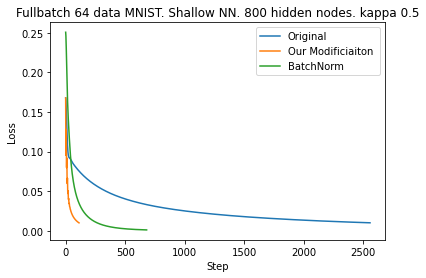

In [ ]:
    plt.plot(outLCNN[0][0],'-',label='Original')
    plt.plot(outLCNN[1][0],'-',label='Our Modificiaiton ')
    plt.plot(outBN[0][0],'-',label='BatchNorm')
    #plt.plot(outBN[1][0],'--',color='green',label='First+BN')

    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')
    #plt.xlim([0,100])

    plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. kappa 0.5')
    plt.savefig('/content/drive/My Drive/LCNN/plot/BN1.pdf')

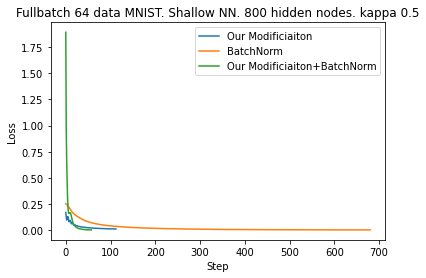

In [ ]:
    #plt.plot(outLCNN[0][0],'-',label='Orginal')
    plt.plot(outLCNN[1][0],'-',label='Our Modificiaiton ')
    plt.plot(outBN[0][0],'-',label='BatchNorm')
    plt.plot(outBN[1][0],'-',label='Our Modificiaiton+BatchNorm')

    plt.legend()
    plt.ylabel('Loss')
    plt.xlabel('Step')
    #plt.xlim([0,100])

    plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. kappa 0.5')
    plt.savefig('/content/drive/My Drive/LCNN/plot/BN2.pdf')

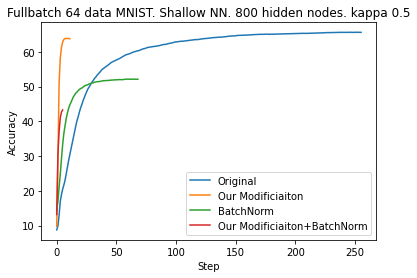

In [ ]:
    plt.plot(outLCNN[0][1],'-',label='Original')
    plt.plot(outLCNN[1][1],'-',label='Our Modificiaiton ')
    plt.plot(outBN[0][1],'-',label='BatchNorm')
    plt.plot(outBN[1][1],'-',label='Our Modificiaiton+BatchNorm')

    plt.legend()
    plt.ylabel('Accuracy')
    plt.xlabel('Step')
    #plt.xlim([0,100])

    plt.title('Fullbatch 64 data MNIST. Shallow NN. 800 hidden nodes. kappa 0.5')
    plt.savefig('/content/drive/My Drive/LCNN/plot/BN3.pdf')